Celda 1: Importar librerías, configurar semilla y parámetros iniciales

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Configuración de la semilla para reproducibilidad
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# Parámetros globales
LATENT_DIM = 100
BATCH_SIZE = 32
EPOCHS = 100

Usando dispositivo: cuda


Celda 2: Cargar y preprocesar el dataset Fashion MNIST

In [2]:
# Definimos la transformación: convertir a tensor y escalar a [0,1],
# luego reescalamos a [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte a tensor y escala a [0,1]
    transforms.Lambda(lambda x: (x - 0.5) * 2)  # Reescala a [-1,1]
])

# Descargar y cargar el dataset (solo la parte de entrenamiento, ignoramos las etiquetas)
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Creamos el DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("Dataset cargado y preprocesado. Tamaño del dataset:", len(train_dataset))

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.52MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 167kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset cargado y preprocesado. Tamaño del dataset: 60000


Celda 3: Definir el generador y el discriminador

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(Generator, self).__init__()
        self.fc = nn.Linear(latent_dim, 7 * 7 * 256, bias=False)
        self.bn0 = nn.BatchNorm1d(7 * 7 * 256)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

        # Redimensionamos: salida esperada (batch, 256, 7, 7)
        # Primera capa de deconvolución: 7x7 -> 7x7 (stride=1, padding=2 para kernel=5)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        # Segunda capa de deconvolución: 7x7 -> 14x14
        # Usamos output_padding=1 para alcanzar la dimensión deseada
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        # Capa final: 14x14 -> 28x28, salida 1 canal, activación tanh
        self.deconv3 = nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)

    def forward(self, x):
        # x: (batch, LATENT_DIM)
        x = self.fc(x)                     # (batch, 7*7*256)
        x = self.bn0(x)
        x = self.lrelu(x)
        x = x.view(-1, 256, 7, 7)           # Reshape a (batch, 256, 7, 7)
        x = self.deconv1(x)                # (batch, 128, 7, 7)
        x = self.bn1(x)
        x = self.lrelu(x)
        x = self.deconv2(x)                # (batch, 64, 14, 14)
        x = self.bn2(x)
        x = self.lrelu(x)
        x = self.deconv3(x)                # (batch, 1, 28, 28)
        x = torch.tanh(x)                  # Asegura rango [-1, 1]
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # La entrada es de forma (batch, 1, 28, 28)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2)  # 28 -> 14
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)  # 14 -> 7
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 7, 1)  # Salida de un único valor

    def forward(self, x):
        x = self.conv1(x)   # (batch, 64, 14, 14)
        x = self.lrelu(x)
        x = self.dropout(x)
        x = self.conv2(x)   # (batch, 128, 7, 7)
        x = self.lrelu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = torch.sigmoid(x)  # Para obtener una salida en [0,1]
        return x

# Instanciar los modelos y moverlos al dispositivo
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Mostrar un resumen de la arquitectura (usando print)
print("Resumen del Generador:")
print(generator)
print("\nResumen del Discriminador:")
print(discriminator)

Resumen del Generador:
Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=False)
  (bn0): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
)

Resumen del Discriminador:
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv2)

Celda 4: Prueba de funcionamiento del generador y visualización

Dimensiones de la imagen generada: torch.Size([1, 1, 28, 28])
Rango de valores de la imagen generada: de -0.33828866481781006 a 0.30182838439941406


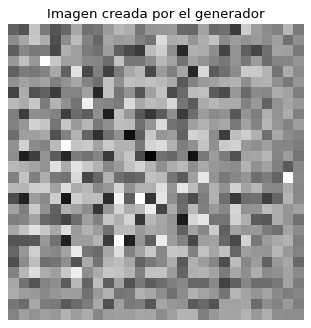

Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=False)
  (bn0): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
)

In [5]:
# Ponemos el generador en modo evaluación para evitar errores en BatchNorm con batch_size=1
generator.eval()

# Generar un vector latente aleatorio (ruido)
noise = torch.randn(1, LATENT_DIM, device=device)
with torch.no_grad():
    generated_image = generator(noise)

print("Dimensiones de la imagen generada:", generated_image.shape)
print("Rango de valores de la imagen generada: de", generated_image.min().item(), "a", generated_image.max().item())

# Mover la imagen a CPU para visualizarla y reescalar de [-1,1] a [0,1]
generated_image_cpu = (generated_image.cpu().squeeze(0).squeeze(0) + 1) / 2

plt.figure(dpi=80)
plt.imshow(generated_image_cpu.numpy(), cmap='gray')
plt.axis("off")
plt.title("Imagen creada por el generador")
plt.show()

# Si lo deseas, vuelve a poner el modelo en modo entrenamiento para continuar con el entrenamiento
generator.train()

Celda 5: Prueba del discriminador con imagen generada


In [7]:
# Ponemos ambos modelos en modo evaluación para evitar errores en BatchNorm con batch_size=1
generator.eval()
discriminator.eval()

# Generar una imagen usando un vector latente aleatorio (ruido)
noise = torch.randn(1, LATENT_DIM, device=device)
with torch.no_grad():
    generated_image = generator(noise)
    decision = discriminator(generated_image)

print("Decisión del discriminador (valor cercano a 0 = falsa, 1 = real):", decision.cpu().numpy())

# Si se requiere seguir entrenando, volver a poner los modelos en modo entrenamiento
generator.train()
discriminator.train()

Decisión del discriminador (valor cercano a 0 = falsa, 1 = real): [[0.5035334]]


Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=1, bias=True)
)

Celda 6: Entrenamiento de la GAN


In [8]:
# Definir la función de pérdida y los optimizadores
criterion = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

print("Inicio del entrenamiento de la GAN...\n")
for epoch in range(EPOCHS):
    total_disc_loss = 0.0
    total_gen_loss = 0.0
    batch_count = 0

    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_count += 1
        current_batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Etiquetas reales y falsas
        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        ####### Actualización del Discriminador #######
        discriminator_optimizer.zero_grad()

        # Evaluación en imágenes reales
        real_output = discriminator(real_images)
        loss_real = criterion(real_output, real_labels)

        # Generar imágenes falsas
        noise = torch.randn(current_batch_size, LATENT_DIM, device=device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())  # detach para no afectar al generador
        loss_fake = criterion(fake_output, fake_labels)

        # Pérdida total del discriminador y actualización
        disc_loss = loss_real + loss_fake
        disc_loss.backward()
        discriminator_optimizer.step()

        ####### Actualización del Generador #######
        generator_optimizer.zero_grad()
        # Generar imágenes y obtener la predicción del discriminador
        noise = torch.randn(current_batch_size, LATENT_DIM, device=device)
        fake_images = generator(noise)
        # El generador quiere que el discriminador clasifique las imágenes como reales
        fake_output = discriminator(fake_images)
        gen_loss = criterion(fake_output, real_labels)
        gen_loss.backward()
        generator_optimizer.step()

        total_disc_loss += disc_loss.item()
        total_gen_loss += gen_loss.item()

    avg_disc_loss = total_disc_loss / batch_count
    avg_gen_loss = total_gen_loss / batch_count

    print(f"Época {epoch+1}/{EPOCHS} - Pérdida Discriminador: {avg_disc_loss:.4f}, Pérdida Generador: {avg_gen_loss:.4f}")

    # Cada 5 épocas se guardan los modelos y se genera una cuadrícula de imágenes de ejemplo
    if (epoch + 1) % 5 == 0:
        # Guardar los modelos
        torch.save(generator.state_dict(), f"fashion_mnist_generador_epoch{epoch+1}.pt")
        torch.save(discriminator.state_dict(), f"fashion_mnist_discriminador_epoch{epoch+1}.pt")

        # Generar 9 imágenes de ejemplo
        noise = torch.randn(9, LATENT_DIM, device=device)
        with torch.no_grad():
            generated_images = generator(noise)
        # Reescalar de [-1, 1] a [0, 1]
        generated_images = (generated_images + 1) / 2
        generated_images = generated_images.cpu()

        # Configurar la cuadrícula 3x3
        fig, axes = plt.subplots(3, 3, figsize=(6, 6))
        for idx, ax in enumerate(axes.flat):
            # Se extrae el canal único y se muestra en escala de grises
            ax.imshow(generated_images[idx].squeeze(0).numpy(), cmap="gray")
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"img_train_epoch{epoch+1}.png")
        plt.close(fig)

Inicio del entrenamiento de la GAN...

Época 1/100 - Pérdida Discriminador: 0.6524, Pérdida Generador: 2.3616
Época 2/100 - Pérdida Discriminador: 0.8156, Pérdida Generador: 1.7187
Época 3/100 - Pérdida Discriminador: 0.7218, Pérdida Generador: 1.8771
Época 4/100 - Pérdida Discriminador: 0.7674, Pérdida Generador: 1.8251
Época 5/100 - Pérdida Discriminador: 0.8494, Pérdida Generador: 1.6320
Época 6/100 - Pérdida Discriminador: 0.8888, Pérdida Generador: 1.5190
Época 7/100 - Pérdida Discriminador: 0.9448, Pérdida Generador: 1.3984
Época 8/100 - Pérdida Discriminador: 0.9891, Pérdida Generador: 1.3125
Época 9/100 - Pérdida Discriminador: 1.0200, Pérdida Generador: 1.2808
Época 10/100 - Pérdida Discriminador: 1.0391, Pérdida Generador: 1.2463
Época 11/100 - Pérdida Discriminador: 1.0423, Pérdida Generador: 1.2284
Época 12/100 - Pérdida Discriminador: 1.0826, Pérdida Generador: 1.1711
Época 13/100 - Pérdida Discriminador: 1.0906, Pérdida Generador: 1.1795
Época 14/100 - Pérdida Discriminad